In [68]:
''' 
This code reproduces the example described in pysystemtrade´s Introduction page (https://github.com/robcarver17/pysystemtrade/blob/master/docs/introduction.md).
I enriched the code with improved visualization.
'''

# This ensures that our graphs will be shown properly in the notebook.
%matplotlib inline

# import necessary dependencies
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as tck

# Import pysystemtrade functions that we need
from sysdata.csv.csv_sim_futures_data import csvFuturesSimData

# Upload futures data
data=csvFuturesSimData()

# Let´s explore the data a little bit to see what we have
print('Instrument list: ')
print(data.get_instrument_list())
instrument_code = 'LEANHOG'
print(' ')
print('Available info for ', instrument_code, ': ')
print('Raw price'.center(30,'-'))
print(data.get_raw_price(instrument_code).tail(5))
print(' ')
print('Daily price'.center(30,'-'))
print(data.daily_prices(instrument_code).tail(5))
print(' ')
print('Block price move'.center(30,'-'))
print(data.get_value_of_block_price_move(instrument_code))
print(' ')
print('Instrument currency'.center(30,'-'))
print(data.get_instrument_currency(instrument_code))
print(' ')
print('Instrument trading cost'.center(30,'-'))
print(data.get_raw_cost_data(instrument_code))
print(' ')
print('Instrument carry data'.center(30,'-'))
print(data.get_instrument_raw_carry_data(instrument_code).tail(6))

Instrument list: 
['AEX', 'AUD', 'BOBL', 'BTP', 'BUND', 'CAC', 'COPPER', 'CORN', 'CRUDE_W', 'EDOLLAR', 'EUR', 'EUROSTX', 'GAS_US', 'GBP', 'GOLD', 'JPY', 'KOSPI', 'KR10', 'KR3', 'LEANHOG', 'LIVECOW', 'MXP', 'NASDAQ', 'NZD', 'OAT', 'PALLAD', 'PLAT', 'SHATZ', 'SMI', 'SOYBEAN', 'SP500', 'US10', 'US2', 'US20', 'US5', 'V2X', 'VIX', 'WHEAT']
 
Available info for  LEANHOG : 
----------Raw price-----------
index
2020-05-12 15:20:27     NaN
2020-05-12 16:32:12     NaN
2020-05-12 17:32:55     NaN
2020-05-12 18:33:53     NaN
2020-05-12 23:00:00    61.5
Name: price, dtype: float64
 
---------Daily price----------
index
2020-05-06    63.950
2020-05-07    63.325
2020-05-08    61.650
2020-05-11    60.600
2020-05-12    61.500
Freq: B, Name: price, dtype: float64
 
-------Block price move-------
LEANHOG
400
 
-----Instrument currency------
LEANHOG
USD
 
---Instrument trading cost----
LEANHOG
{'price_slippage': 0.025, 'value_of_block_commission': 2.9, 'percentage_cost': 0.0, 'value_of_pertrade_commission

In [69]:
# import necessary dependencies
from syscore.algos import robust_vol_calc


def calc_ewmac_forecast(price, Lfast, Lslow=None):
    """    
    Calculate the ewmac trading rule forecast, given a price and EWMA speeds
    Lfast, Lslow and vol_lookback
    """
    # price: This is the stitched price series
    # We can't use the price of the contract we're trading, or the volatility
    # will be jumpy
    # And we'll miss out on the rolldown. See
    # http://qoppac.blogspot.co.uk/2015/05/systems-building-futures-rolling.html

    price = price.resample("1B").last()

    if Lslow is None:
        Lslow = 4 * Lfast

    # We don't need to calculate the decay parameter, just use the span
    # directly
    fast_ewma = price.ewm(span=Lfast).mean()
    slow_ewma = price.ewm(span=Lslow).mean()
    raw_ewmac = fast_ewma - slow_ewma

    vol = robust_vol_calc(price.diff())
    return raw_ewmac / vol


"""
Calculate two distinct ewmac for the instrument_code
"""
price = data.daily_prices(instrument_code)
ewmac_st = calc_ewmac_forecast(price, 14, 56)
ewmac_mt = calc_ewmac_forecast(price, 21, 84)
ewmac_lt = calc_ewmac_forecast(price, 63, 252)


Main Statistics - Instrument:  LEANHOG

                         EWMAC_ST        EWMAC_MT        EWMAC_LT
Gross Returns:         158,739.11      155,829.59      112,356.74
Net Returns:           158,739.11      155,829.59      112,356.74
Annual Volatility:     461,415.07      550,416.82      917,507.64
Sharpe Ratio:                0.34            0.28            0.12
Avg Drawdown:         -598,874.64     -778,954.24   -1,759,627.81
Avg Gain:               18,357.22       21,919.70       35,470.77
Avg Loss:              -17,472.92      -21,348.77      -35,699.65
Gain / Loss:                 1.05            1.03            0.99
Skew:                       -0.13           -0.12           -0.08
Positive days            5,791.00        5,817.00        5,814.00
Negative days            5,649.00        5,623.00        5,626.00
% Positive days              0.47            0.47            0.47
% Negative days              0.46            0.46            0.46



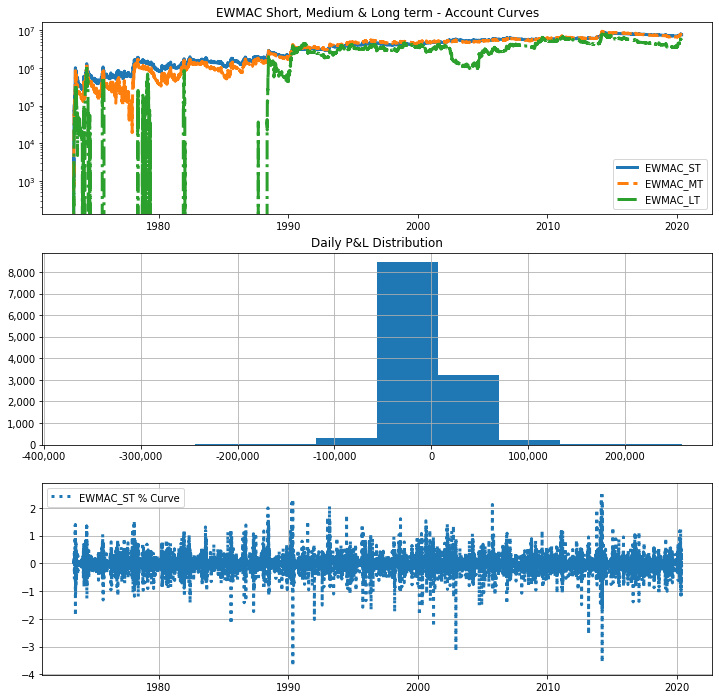

In [70]:
"""
Did we make money?
"""

from syscore.accounting import accountCurve
account_st = accountCurve(price, forecast=ewmac_st)
account_mt = accountCurve(price, forecast=ewmac_mt)
account_lt = accountCurve(price, forecast=ewmac_lt)

#account_st.curve()
#account_mt.curve()
#account_lt.curve()

dailypnl_st = account_st.curve().diff().dropna()
dailypnl_mt = account_mt.curve().diff().dropna()
dailypnl_lt = account_lt.curve().diff().dropna()


# Make  new figure and set the size.
#fig = plt.figure(figsize=(12, 8))
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(12, 12))

# The first subplot, planning for 3 plots high, 1 plot wide, this being the first.
#ax = fig.add_subplot(311)
axs[0].set_title('EWMAC Short, Medium & Long term - Account Curves')
axs[0].semilogy(account_st.curve(), linestyle='-', label='EWMAC_ST', linewidth=3.0)
axs[0].semilogy(account_mt.curve(), linestyle='--', label='EWMAC_MT', linewidth=3.0)
axs[0].semilogy(account_lt.curve(), linestyle='-.', label='EWMAC_LT', linewidth=3.0)
axs[0].legend()
axs[0].grid(False)

# Second sub plot.
#ax = fig.add_subplot(312)
n_st, bins_st, patches_st = axs[1].hist(dailypnl_st)
axs[1].set_title('Daily P&L Distribution')
axs[1].get_xaxis().set_major_formatter(tck.FuncFormatter(lambda x, p: format(int(x), ',')))
axs[1].get_yaxis().set_major_formatter(tck.FuncFormatter(lambda y, p: format(int(y), ',')))
axs[1].grid(True)

# Third subplot.
#ax = fig.add_subplot(313)
axs[2].plot(account_st.percent(), label='EWMAC_ST % Curve', linestyle=':', linewidth=3.0)
axs[2].legend()
axs[2].grid(True)

print('Main Statistics - Instrument: ', instrument_code)
print()
print('                         EWMAC_ST        EWMAC_MT        EWMAC_LT')
print ('Gross Returns:     {:14,.2f}'.format(account_st.gross.ann_mean()), 
                         ' {:14,.2f}'.format(account_mt.gross.ann_mean()),
                         ' {:14,.2f}'.format(account_lt.gross.ann_mean()))
print ('Net Returns:       {:14,.2f}'.format(account_st.net.ann_mean()), 
                         ' {:14,.2f}'.format(account_mt.net.ann_mean()),
                         ' {:14,.2f}'.format(account_lt.net.ann_mean()))
print ('Annual Volatility: {:14,.2f}'.format(account_st.ann_std()),
                         ' {:14,.2f}'.format(account_mt.ann_std()),
                         ' {:14,.2f}'.format(account_lt.ann_std()))
print ('Sharpe Ratio:      {:14,.2f}'.format(account_st.sharpe()),
                         ' {:14,.2f}'.format(account_mt.sharpe()),
                         ' {:14,.2f}'.format(account_lt.sharpe()))
print ('Avg Drawdown:      {:14,.2f}'.format(account_st.avg_drawdown()),
                         ' {:14,.2f}'.format(account_mt.avg_drawdown()),
                         ' {:14,.2f}'.format(account_lt.avg_drawdown()))
print ('Avg Gain:          {:14,.2f}'.format(account_st.avg_gain()),
                         ' {:14,.2f}'.format(account_mt.avg_gain()),
                         ' {:14,.2f}'.format(account_lt.avg_gain()))
print ('Avg Loss:          {:14,.2f}'.format(account_st.avg_loss()),
                         ' {:14,.2f}'.format(account_mt.avg_loss()),
                         ' {:14,.2f}'.format(account_lt.avg_loss()))
print ('Gain / Loss:       {:14,.2f}'.format(account_st.gaintolossratio()),
                         ' {:14,.2f}'.format(account_mt.gaintolossratio()),
                         ' {:14,.2f}'.format(account_lt.gaintolossratio()))
print ('Skew:              {:14,.2f}'.format(account_st.skew()),
                         ' {:14,.2f}'.format(account_mt.skew()),
                         ' {:14,.2f}'.format(account_lt.skew()))
print ('Positive days      {:14,.2f}'.format(dailypnl_st[dailypnl_st > 0].count()),
                         ' {:14,.2f}'.format(dailypnl_mt[dailypnl_mt > 0].count()),
                         ' {:14,.2f}'.format(dailypnl_lt[dailypnl_lt > 0].count()))
print ('Negative days      {:14,.2f}'.format(dailypnl_st[dailypnl_st < 0].count()),
                         ' {:14,.2f}'.format(dailypnl_mt[dailypnl_mt < 0].count()),
                         ' {:14,.2f}'.format(dailypnl_lt[dailypnl_lt < 0].count()))
print ('% Positive days    {:14,.2f}'.format(dailypnl_st[dailypnl_st > 0].count()/                                                      dailypnl_st.count()),
                         ' {:14,.2f}'.format(dailypnl_mt[dailypnl_mt > 0].count()/                                                      dailypnl_mt.count()),
                         ' {:14,.2f}'.format(dailypnl_lt[dailypnl_lt > 0].count()/                                                      dailypnl_lt.count()))
print ('% Negative days    {:14,.2f}'.format(dailypnl_st[dailypnl_st < 0].count()/                                                      dailypnl_st.count()),
                         ' {:14,.2f}'.format(dailypnl_mt[dailypnl_mt < 0].count()/                                                      dailypnl_mt.count()),
                         ' {:14,.2f}'.format(dailypnl_lt[dailypnl_lt < 0].count()/                                                      dailypnl_lt.count()))
print()
#print(account2.percent().stats())


Sharpe Ratio:  0.4557682363882526
Cumulative Account Curve


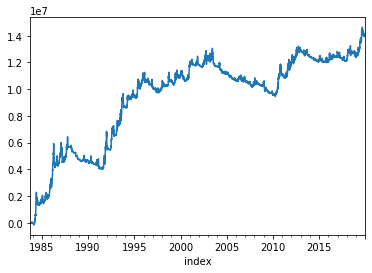

In [71]:
## get the Sharpe Ratio (annualised), and any other statistic which is in the stats list
print ('Sharpe Ratio: ', account.sharpe())

## plot the cumulative account curve (equivalent to account.cumsum().plot() inicidentally)
print('Cumulative Account Curve')
account.curve().plot() 

## gives a % curve
#print('% Curve')
#account.percent().plot()

## see the drawdowns as a percentage
#print('% Drawdowns')
#account.percent().drawdown().plot() 

## annual mean for gross returns, also costs (there are none in this simple example)
#print ('Gross Returns: ', account.gross.ann_mean()) 